# Project 7: Time Series Analysis
Time series analysis for the mean temperature data collected by Berlin weather stations (Tempelhof, Dahlem, Treptow) in the years 1876 to 2021. Data made available by www.ecad.eu. There are some missing data in the time series, but overall the data set is rather consistent and accurate. The data analysis was conducted during the Spiced Academy Data Science Bootcamp.

In [1]:
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
from dateutil import parser
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats
from scipy.stats import jarque_bera
import pylab as py

In [2]:
sns.set()
plt.rcParams['figure.figsize'] = (20, 10)

## 1. Reading data and cleaning the time series data

In [3]:
#Reading mean temperature data dowloaded from ECAD
df = pd.read_csv(os.path.join("data","TG_STAID002759.txt"), names = ['souid', 'date', 'tg', 'q_tg'], 
                 header=0 )

In [4]:
df.head()

,souid,date,tg,q_tg
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [5]:
df.shape

(53051, 4)

In [6]:

df['souid'].unique().tolist() #The data downloaded contains measurements also done by other stations
#About half of the data comes from station 111448 (BERLIN-TEMPELHOF) and 127488 BERLIN-DAHLEM (LFAG),
#only a small portion (364) from station 128124 (BERLIN-TREPTOW)

[127488, 128124, 111448]

In [7]:
df.groupby('souid').count()

,date,tg,q_tg
souid,,,
111448,26754,26754,26754
127488,25933,25933,25933
128124,364,364,364


In [8]:
df.groupby('q_tg').count() #There are 1 suspect and 195 missing data quality labels.

,souid,date,tg
q_tg,,,
0,52855,52855,52855
1,1,1,1
9,195,195,195


In [9]:
df.dtypes

souid    int64
date     int64
tg       int64
q_tg     int64
dtype: object

In [10]:
#Transforming the date column into a pandas datetime object
df['date'] = df['date'].astype(str)

In [11]:
df.dtypes

souid     int64
date     object
tg        int64
q_tg      int64
dtype: object

In [12]:
df['date']= pd.to_datetime(df['date'])

In [13]:
df

,souid,date,tg,q_tg
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0
...,...,...,...,...
53046,111448,2021-03-27,69,0
53047,111448,2021-03-28,77,0
53048,111448,2021-03-29,144,0
53049,111448,2021-03-30,149,0


In [14]:
#Casting the date column as df index
df = df.set_index('date')

In [15]:
df

,souid,tg,q_tg
date,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0
...,...,...,...
2021-03-27,111448,69,0
2021-03-28,111448,77,0
2021-03-29,111448,144,0


In [16]:
# Checking for gaps in the time series
(df.index.to_series().diff()> pd.Timedelta(days=1)).value_counts()

False    53051
Name: date, dtype: int64

In [17]:
temp = df.index.to_series().diff() > pd.Timedelta(days=1)

In [18]:
df.index.to_series().diff().sort_values()

date
1876-01-02   1 days
1972-10-25   1 days
1972-10-26   1 days
1972-10-27   1 days
1972-10-28   1 days
              ...  
1924-06-07   1 days
1924-06-08   1 days
1924-05-29   1 days
2021-03-31   1 days
1876-01-01      NaT
Name: date, Length: 53051, dtype: timedelta64[ns]

In [19]:
#I interpolate the temperature data where they are missing (code -9999) using the avg() of the previous
#and following year
df['q_tg'].astype(int)
bad_data_index = df[df['q_tg']==9 ].index.tolist()

for index in bad_data_index:
    yb = datetime(index.year - 1, index.month, index.day)
    yf = datetime(index.year + 1, index.month, index.day)
    temp_yb = df.at[yb,'tg']
    temp_yf = df.at[yf,'tg']
    repl_val = statistics.mean([temp_yb,temp_yf])
    df.at[index, 'tg'] = repl_val

In [20]:
#Dividing the temperature column by 10 to get Celsius not 0.1 C
df['tg'] = df['tg']/10

In [21]:
#Dropping the data quality control as not helpful anymore
df.drop('q_tg', axis=1, inplace=True)

## 2. Visualising the time series data

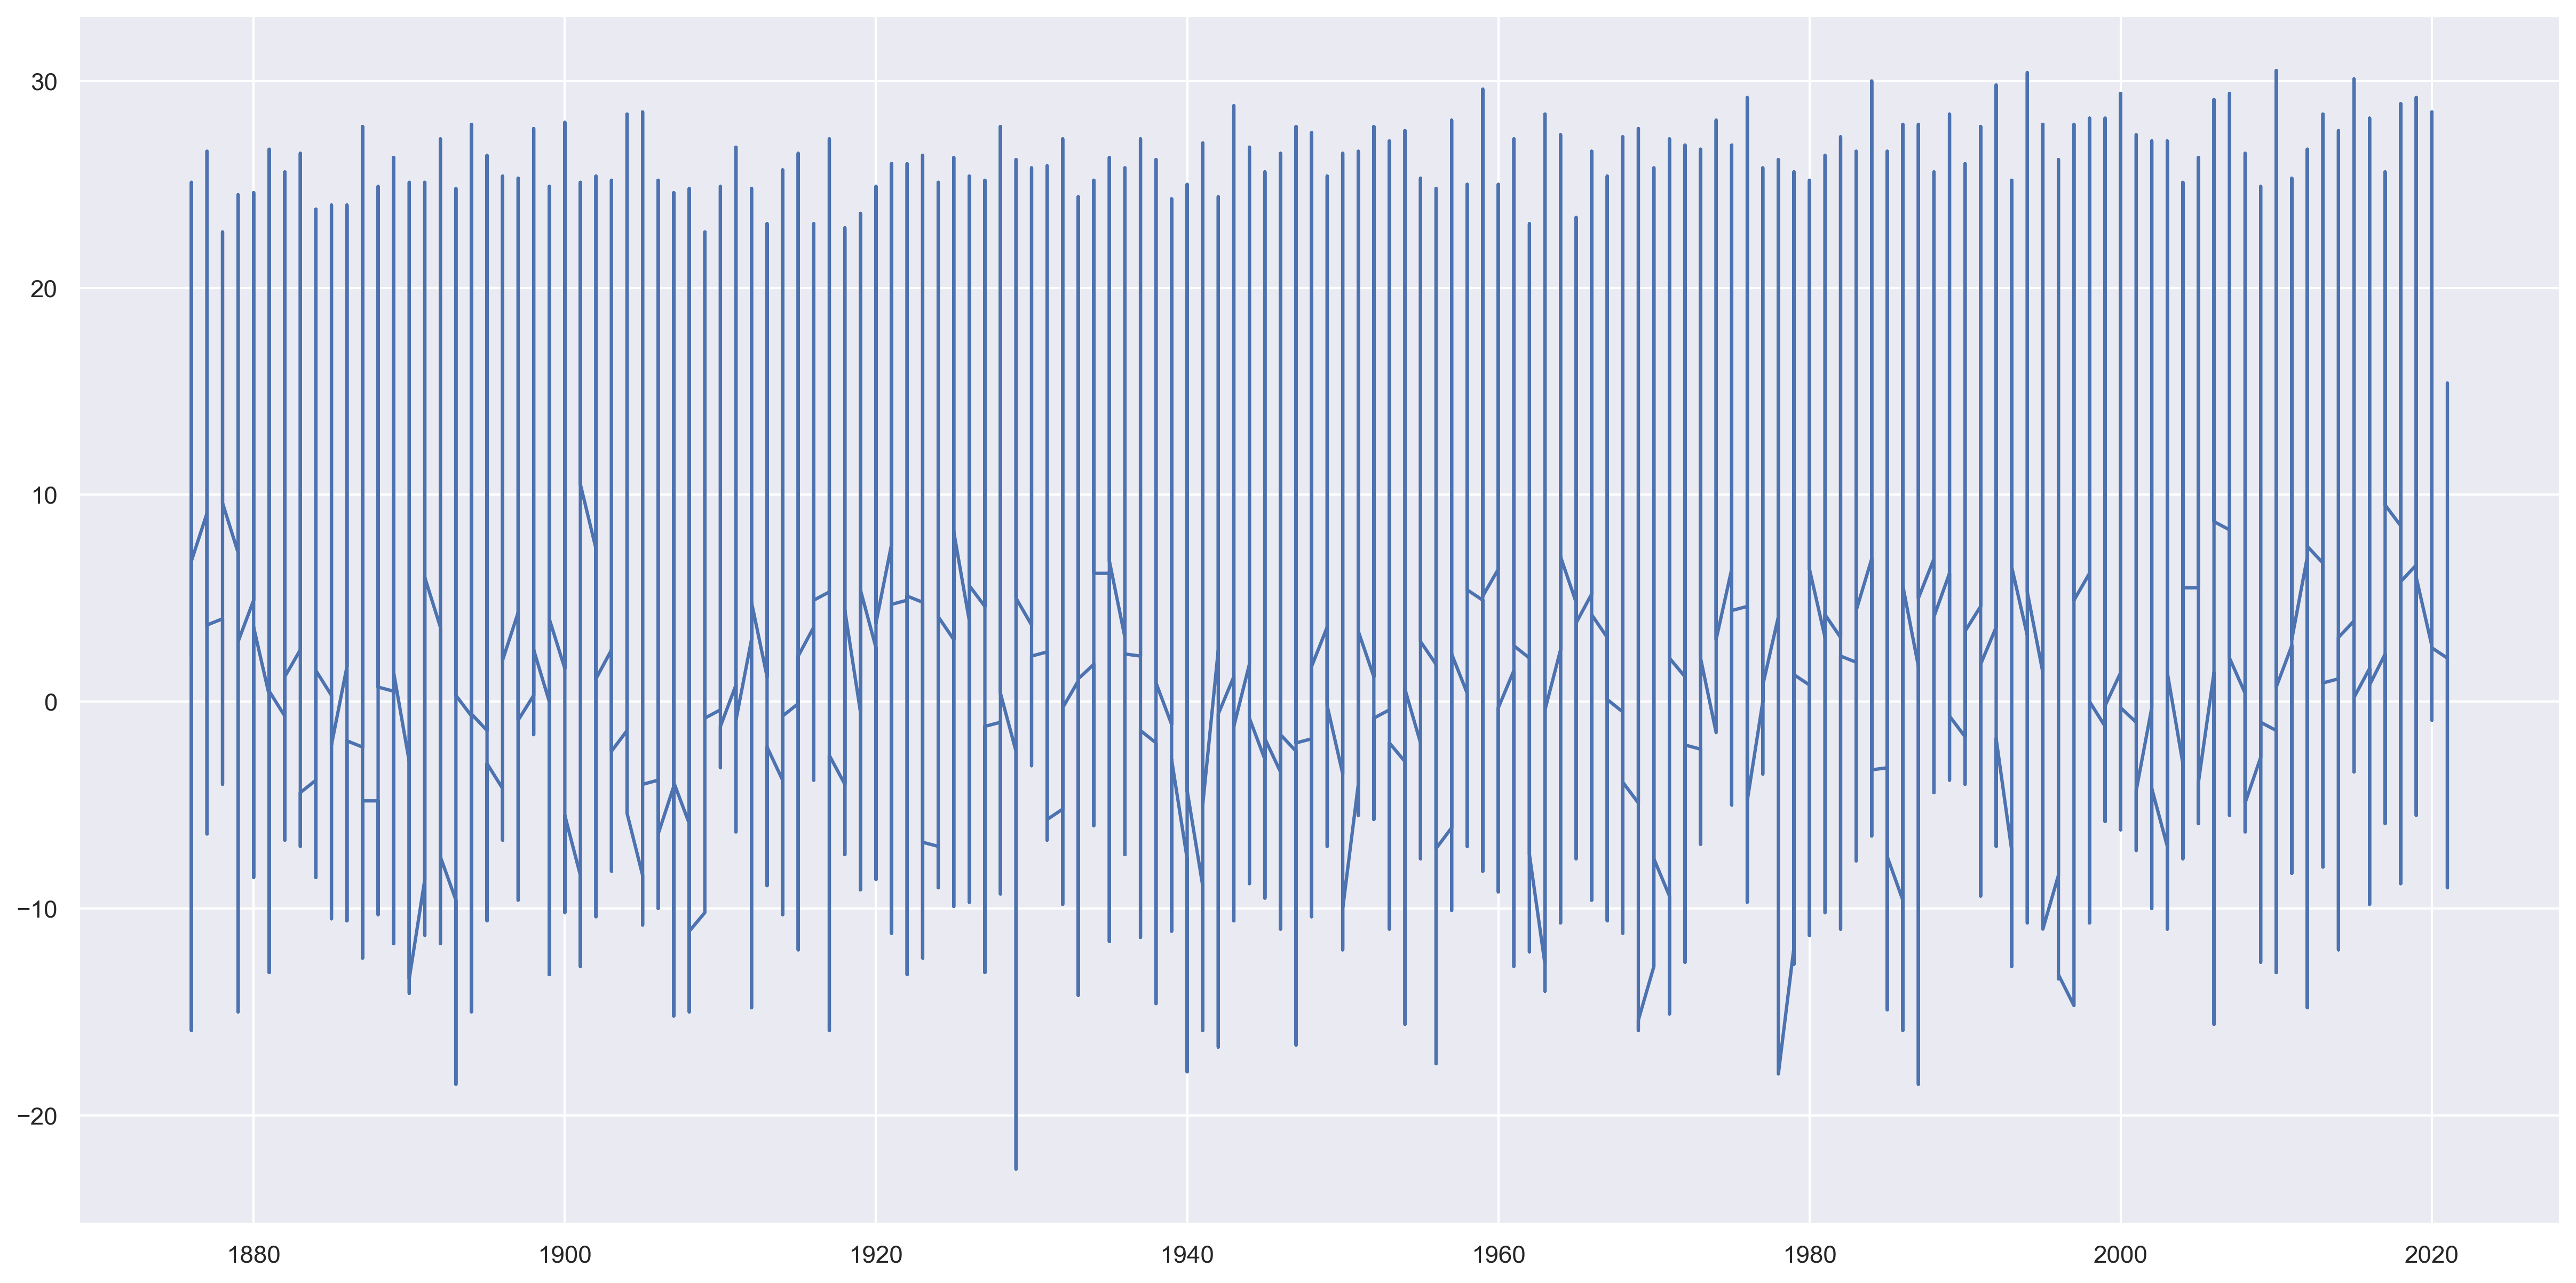

In [22]:
#df.plot(y='tg', use_index=True)

plt.figure(figsize =(20, 10), dpi = 300)
plt.plot(df.index.year, df['tg']);

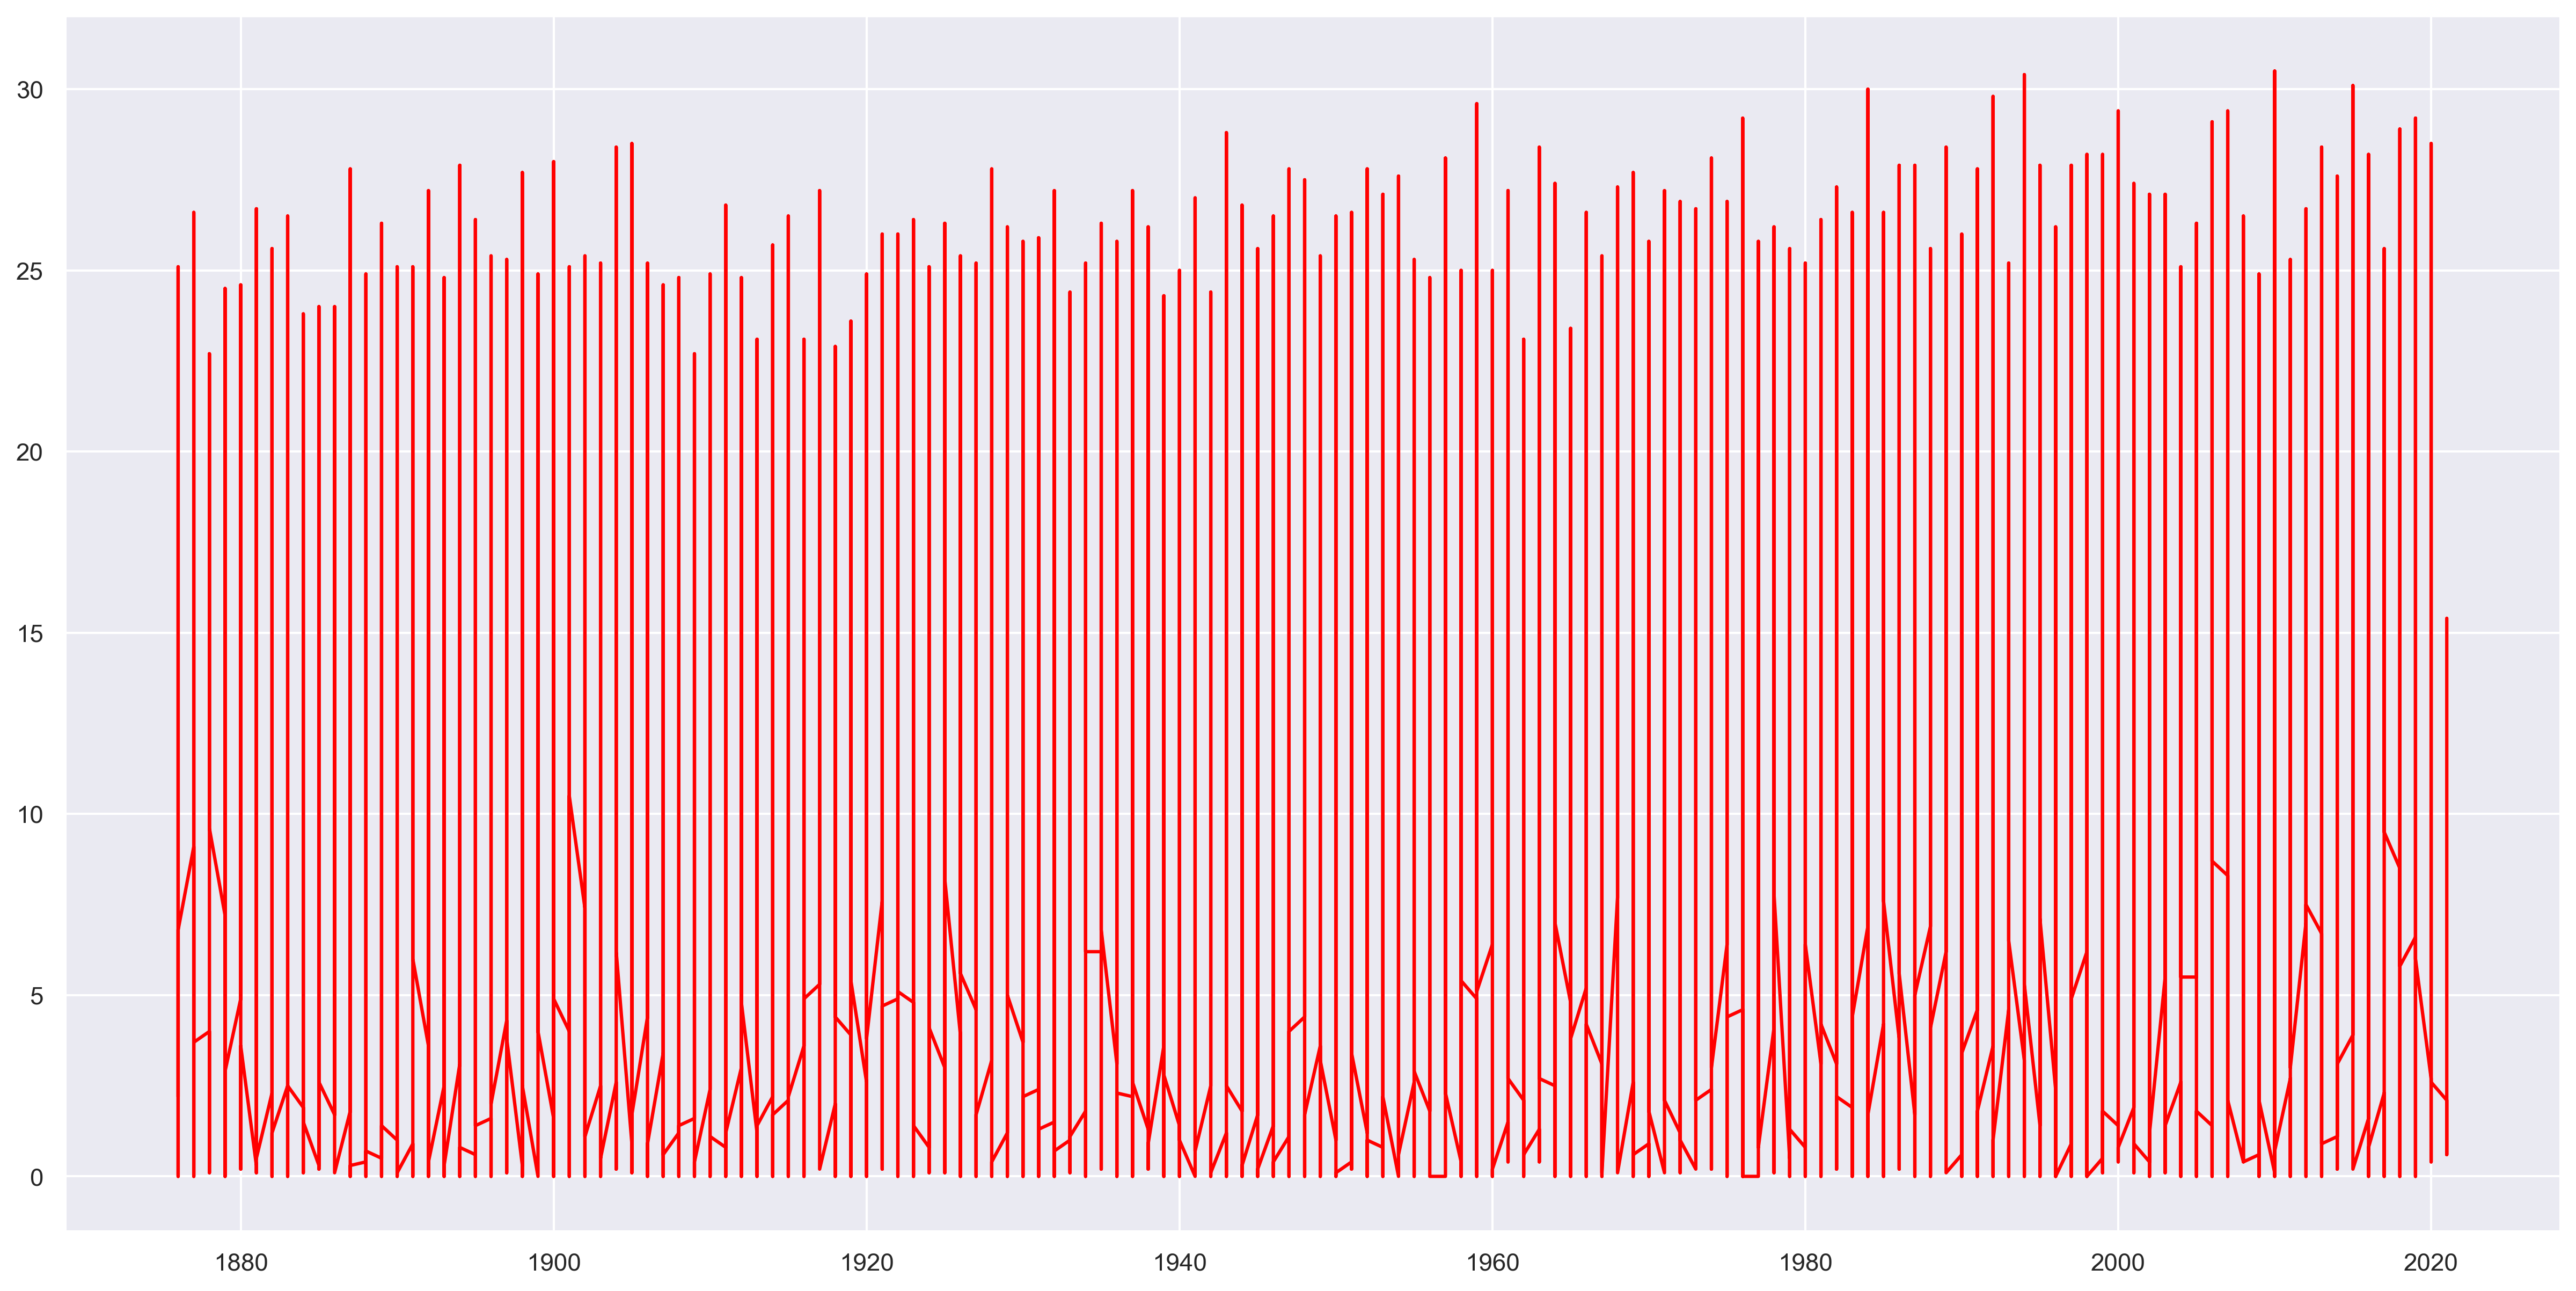

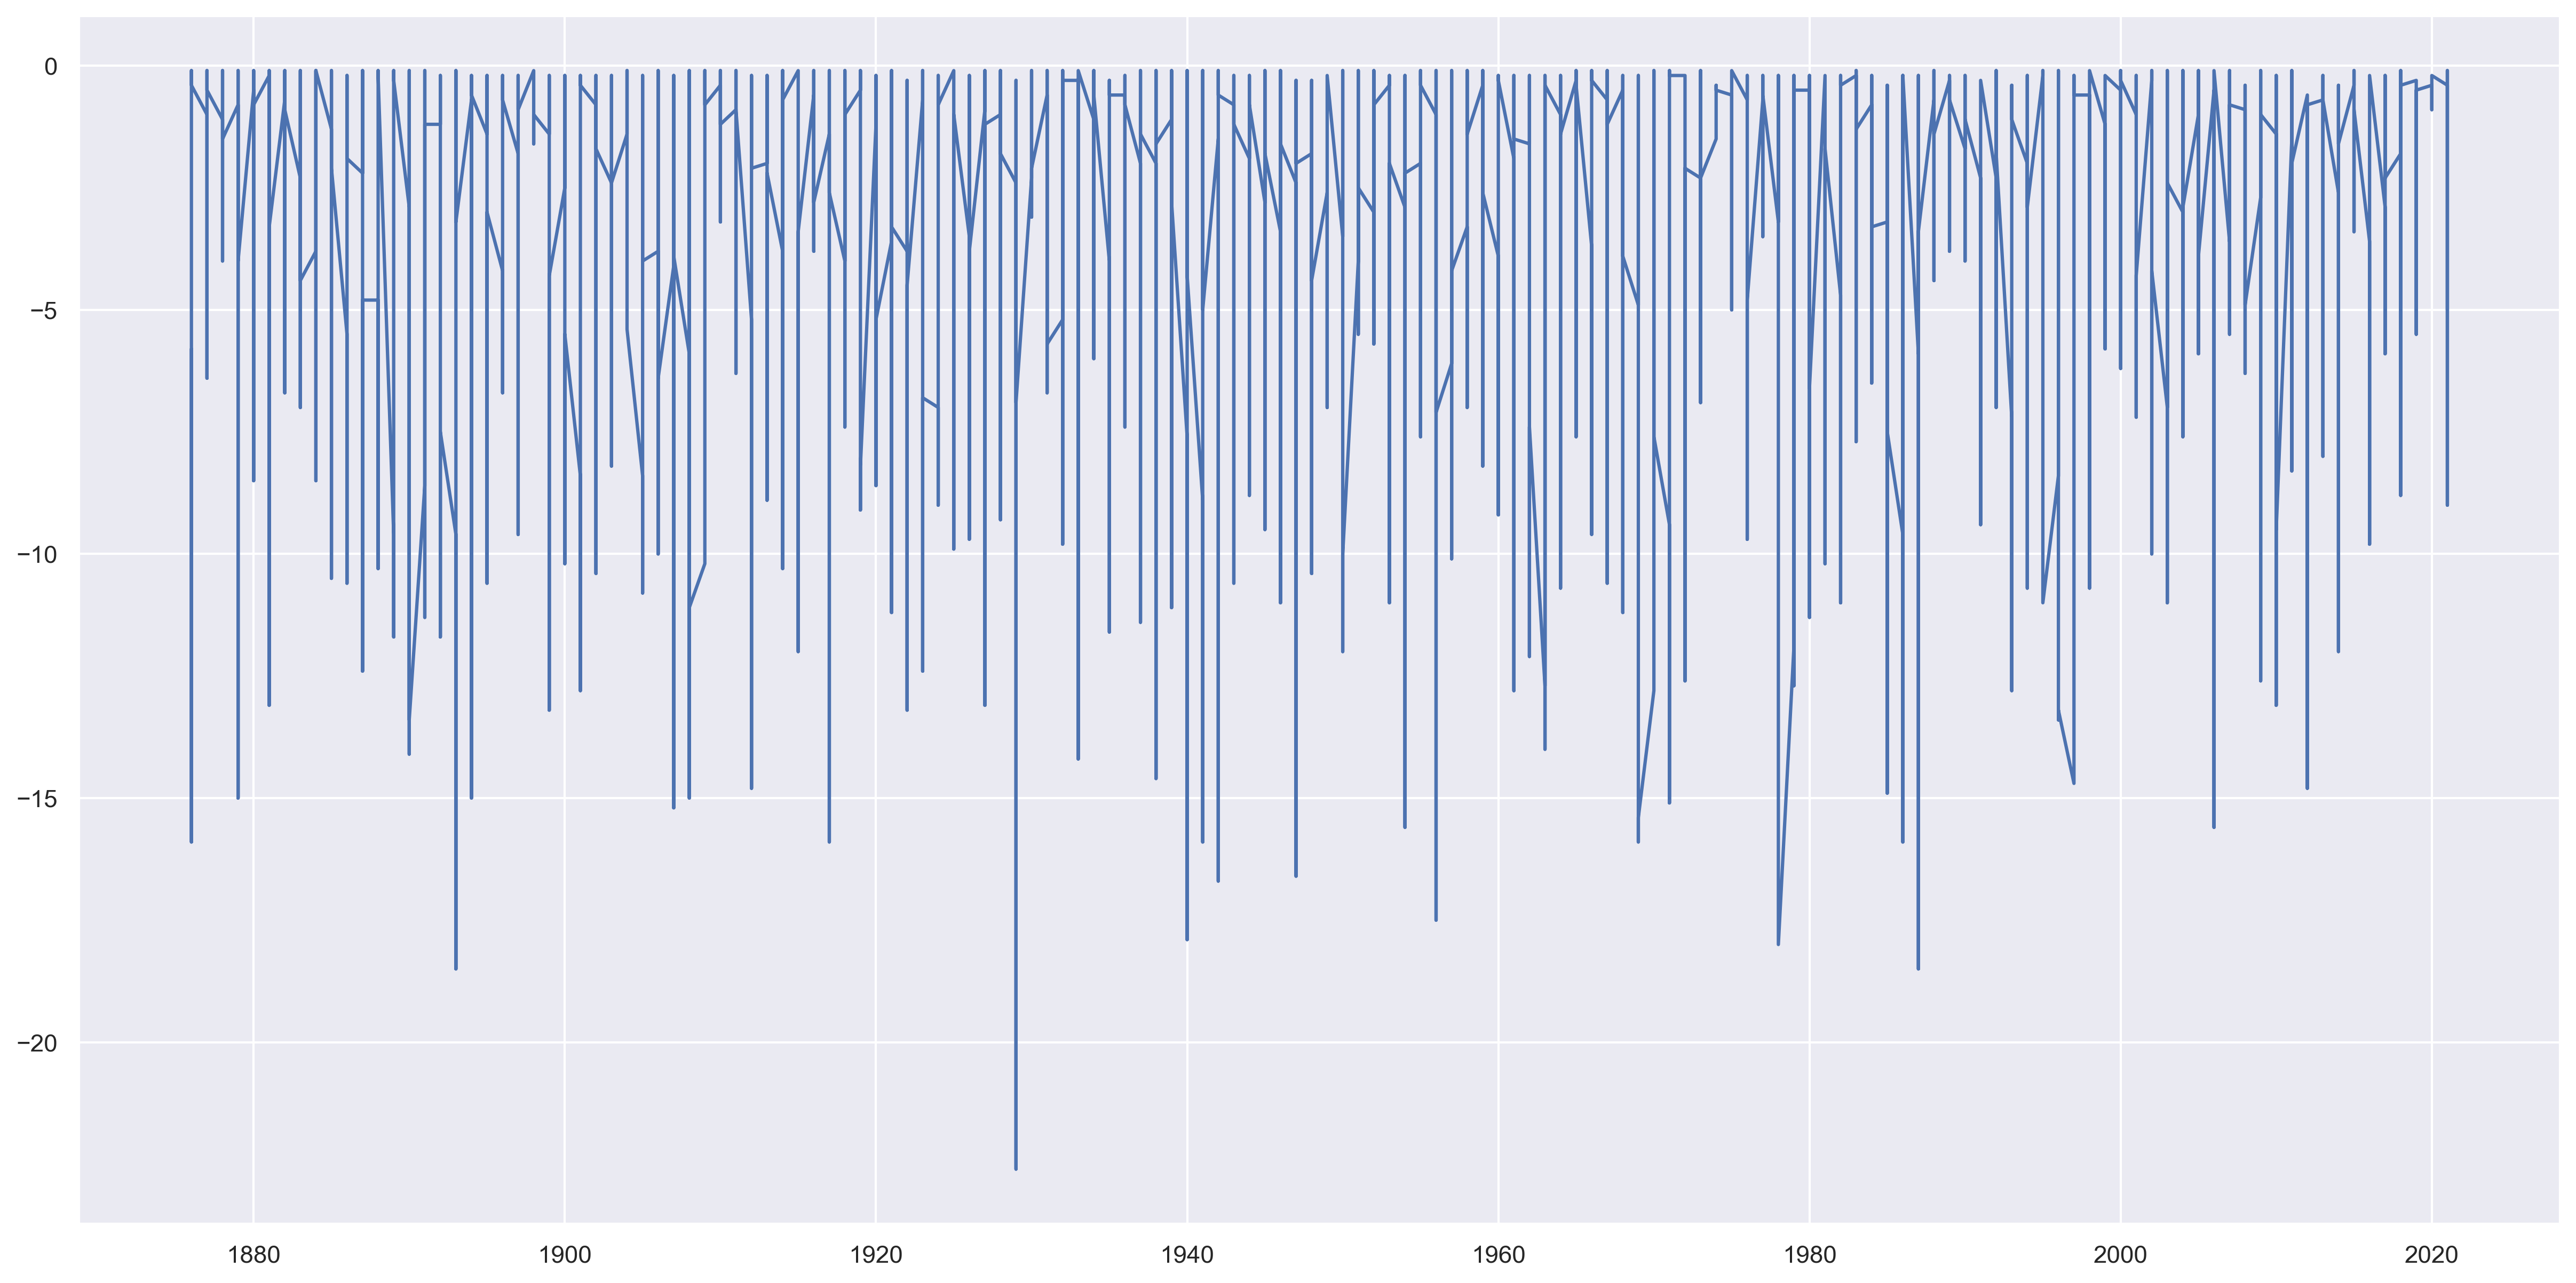

In [23]:
#Examining trends separately for + and - temperatures
mask_plus = df['tg']>=0
df_plus = df.loc[mask_plus]
plt.figure(figsize =(20, 10), dpi = 300)
plt.plot(df_plus.index.year, df_plus['tg'], color = 'red');

mask_minus = df['tg']<0
df_minus = df.loc[mask_minus]
plt.figure(figsize =(20, 10), dpi = 300)
plt.plot(df_minus.index.year, df_minus['tg']);

#The plots suggest that both summer and winter mean daily temperatures are increasing.

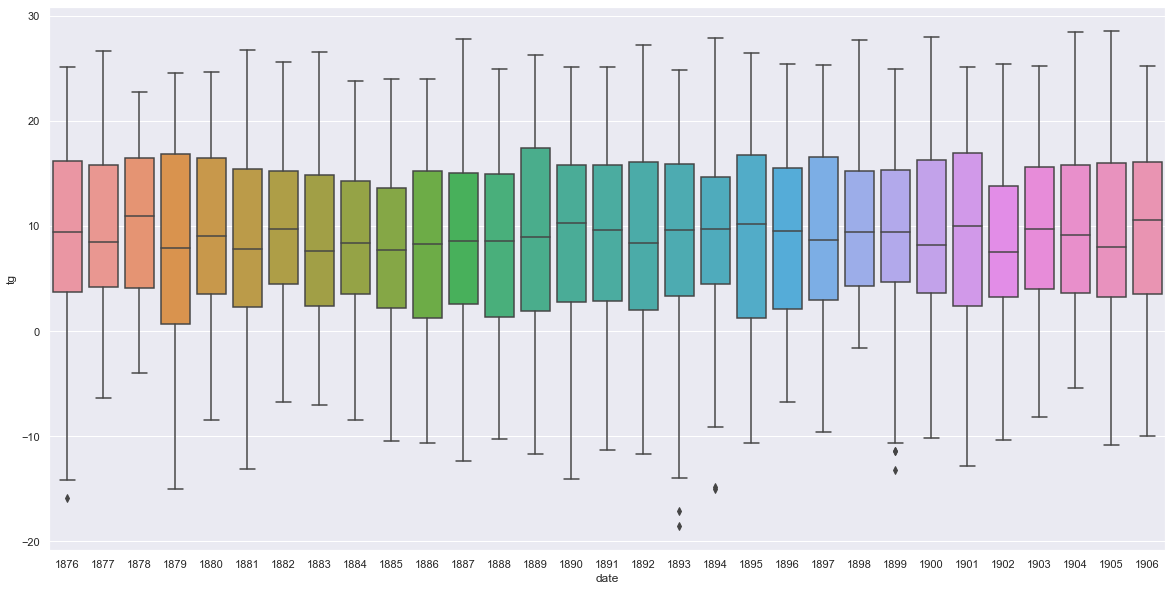

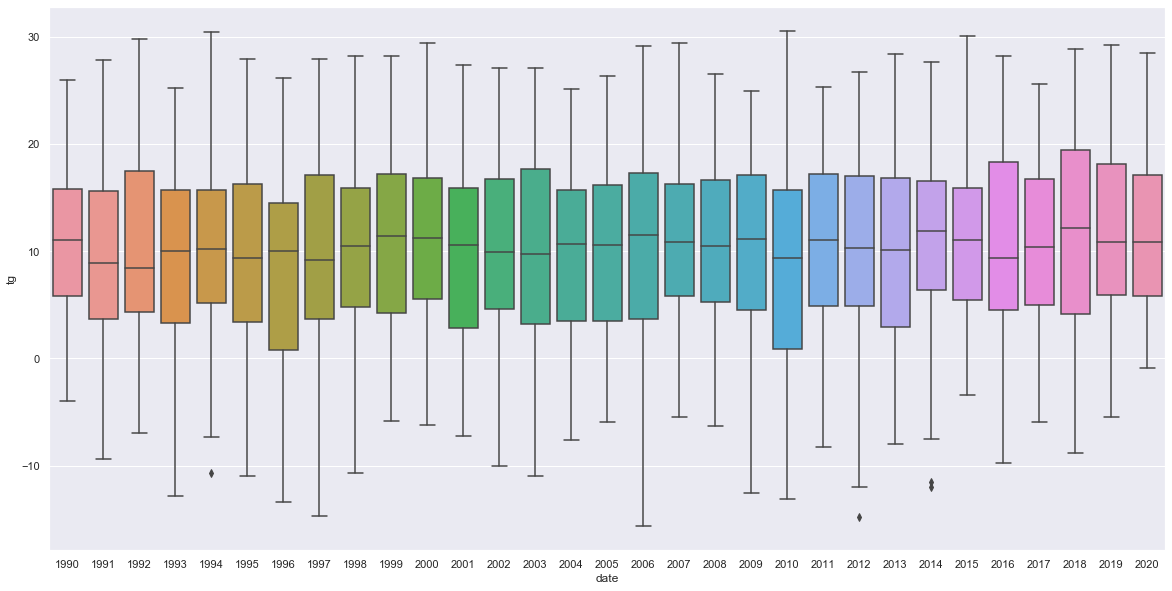

In [24]:
#Boxplot of the mean temperature in the first 30 years of the dataset
mask_early_years = (df.index > '1876-01-01') & (df.index <= '1906-12-31')
df_early_years = df[mask_early_years]
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(df_early_years.index.year, df_early_years.tg, ax=ax)

#Boxplot of the mean temperature in the past 30 years
mask_last_years = (df.index > '1990-01-01') & (df.index <= '2020-12-31')
df_last_years = df[mask_last_years]
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(df_last_years.index.year, df_last_years.tg, ax=ax)

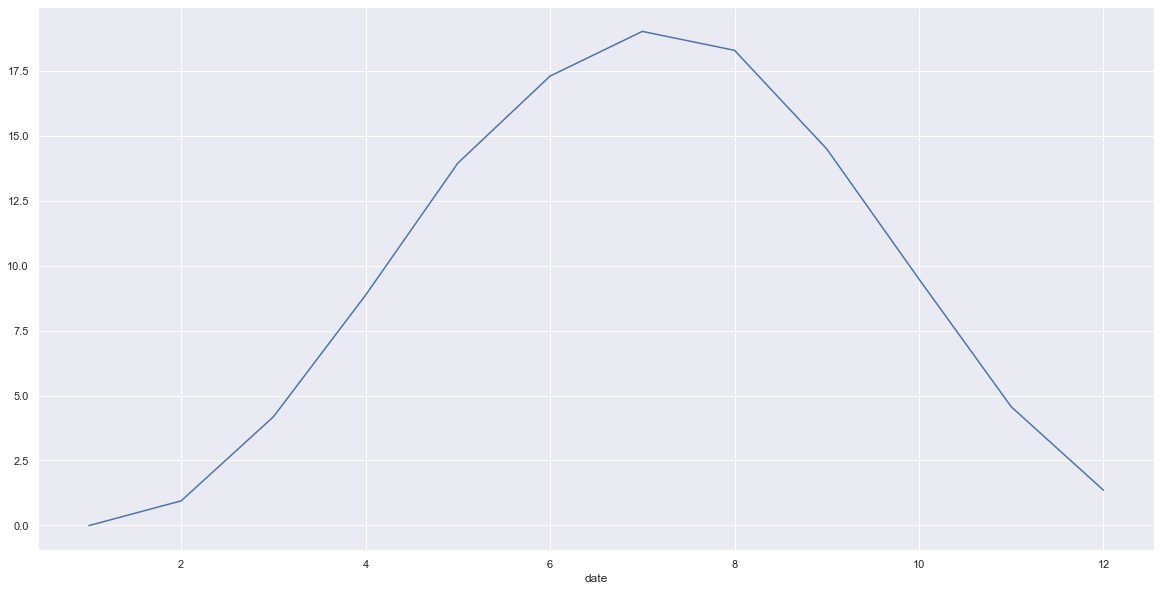

In [25]:
#Seasonality
df.groupby(df.index.month)['tg'].mean().plot();

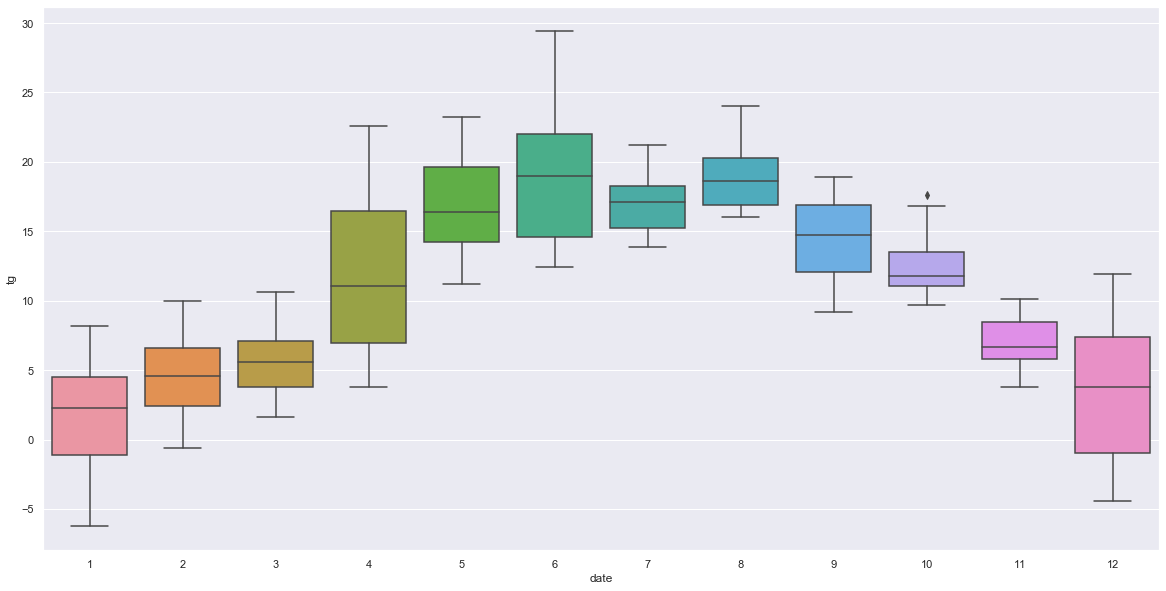

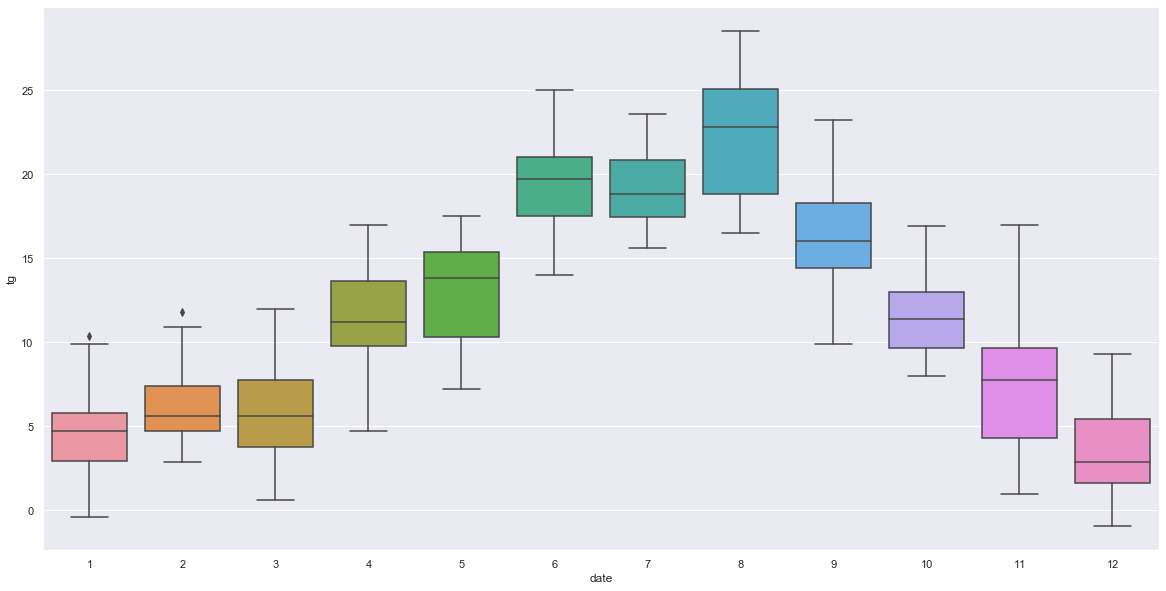

In [26]:
#Exploring seasonality (using recent data)
#Boxplot of the mean temperature in year 2000 and year 2020
mask_t = (df.index > '2000-01-01') & (df.index <= '2000-12-31')
df_t = df[mask_t]
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(df_t.index.month, df_t.tg, ax=ax)

mask_tt = (df.index > '2020-01-01') & (df.index <= '2020-12-31')
df_tt = df[mask_tt]
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(df_tt.index.month, df_tt.tg, ax=ax);

## 3. Modeling the trend

In [27]:
m = LinearRegression()

In [28]:
df['timestep'] = range(len(df))

In [29]:
X = df[['timestep']] #matrix (or DataFrame)
y = df['tg']

In [30]:
X

,timestep
date,
1876-01-01,0
1876-01-02,1
1876-01-03,2
1876-01-04,3
1876-01-05,4
...,...
2021-03-27,53046
2021-03-28,53047
2021-03-29,53048


In [31]:
y

date
1876-01-01     2.2
1876-01-02     2.5
1876-01-03     0.3
1876-01-04    -5.8
1876-01-05    -9.8
              ... 
2021-03-27     6.9
2021-03-28     7.7
2021-03-29    14.4
2021-03-30    14.9
2021-03-31    15.4
Name: tg, Length: 53051, dtype: float64

In [32]:
m.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
m.coef_

array([3.19303575e-05])

In [34]:
df['trend'] = m.predict(X)

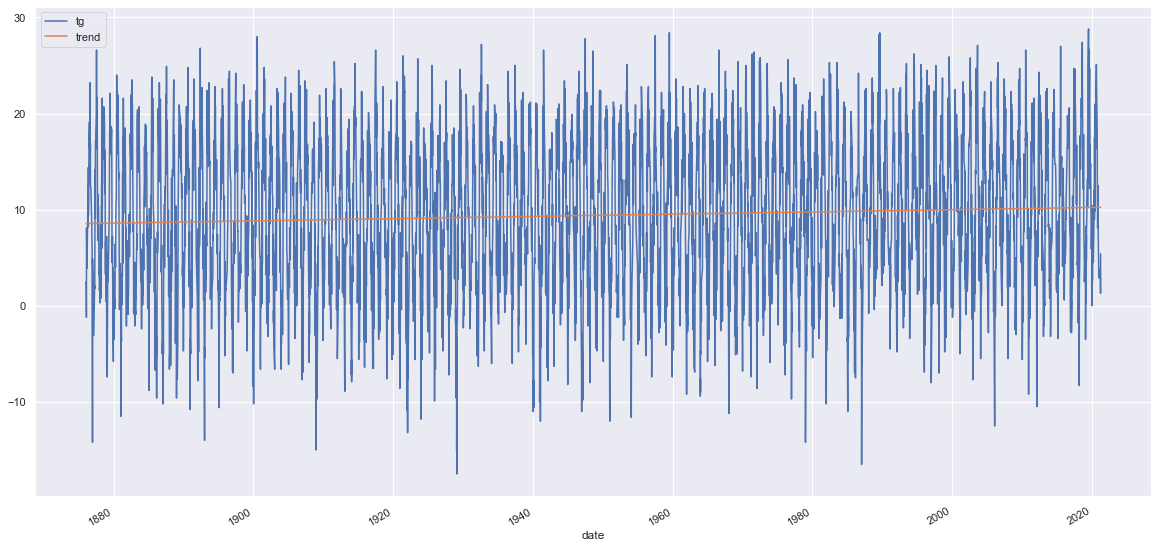

In [35]:
#To improve visualization, I plot only a 5000 data points random sample
df[['tg', 'trend']].sample(n = 5000).plot(figsize=(20,10));

## 4. Modeling the seasonality

In [36]:
df['month'] = df.index.month

In [37]:
seasonal_dummies = pd.get_dummies(df['month'], prefix='month_', drop_first=True)

In [38]:
df = df.merge(seasonal_dummies, left_index=True, right_index=True)

In [39]:
df

,souid,tg,timestep,trend,month,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
date,,,,,,,,,,,,,,,,
1876-01-01,127488,2.2,0,8.552027,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,127488,2.5,1,8.552059,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,127488,0.3,2,8.552091,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,127488,-5.8,3,8.552123,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,127488,-9.8,4,8.552155,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,111448,6.9,53046,10.245805,3,0,1,0,0,0,0,0,0,0,0,0
2021-03-28,111448,7.7,53047,10.245837,3,0,1,0,0,0,0,0,0,0,0,0
2021-03-29,111448,14.4,53048,10.245869,3,0,1,0,0,0,0,0,0,0,0,0


In [40]:
X = df.drop(['souid','tg', 'trend', 'month'], axis=1)

In [41]:
X

,timestep,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
date,,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,53046,0,1,0,0,0,0,0,0,0,0,0
2021-03-28,53047,0,1,0,0,0,0,0,0,0,0,0
2021-03-29,53048,0,1,0,0,0,0,0,0,0,0,0


In [42]:
y = df['tg']

In [43]:
m.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
df['trend_AND_seasonality'] = m.predict(X)

In [45]:
df['trend_AND_seasonality']

date
1876-01-01   -0.873854
1876-01-02   -0.873821
1876-01-03   -0.873788
1876-01-04   -0.873755
1876-01-05   -0.873723
                ...   
2021-03-27    5.048924
2021-03-28    5.048957
2021-03-29    5.048989
2021-03-30    5.049022
2021-03-31    5.049055
Name: trend_AND_seasonality, Length: 53051, dtype: float64

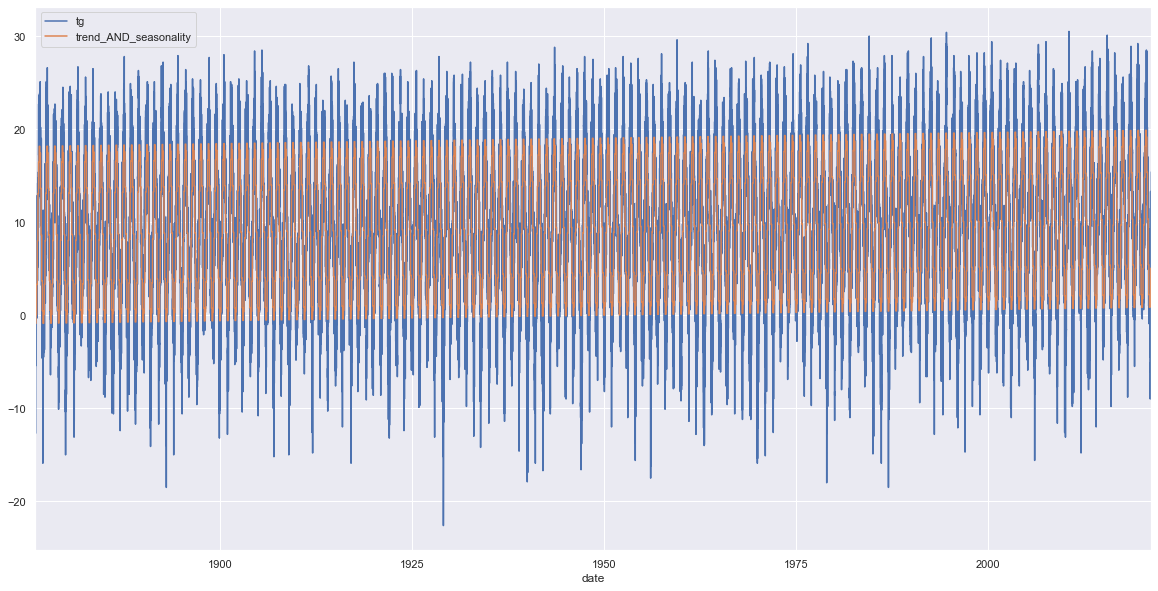

In [46]:
df[['tg', 'trend_AND_seasonality']].plot(figsize=(20,10));

In [47]:
df['remainder'] = df['tg'] - df['trend_AND_seasonality']

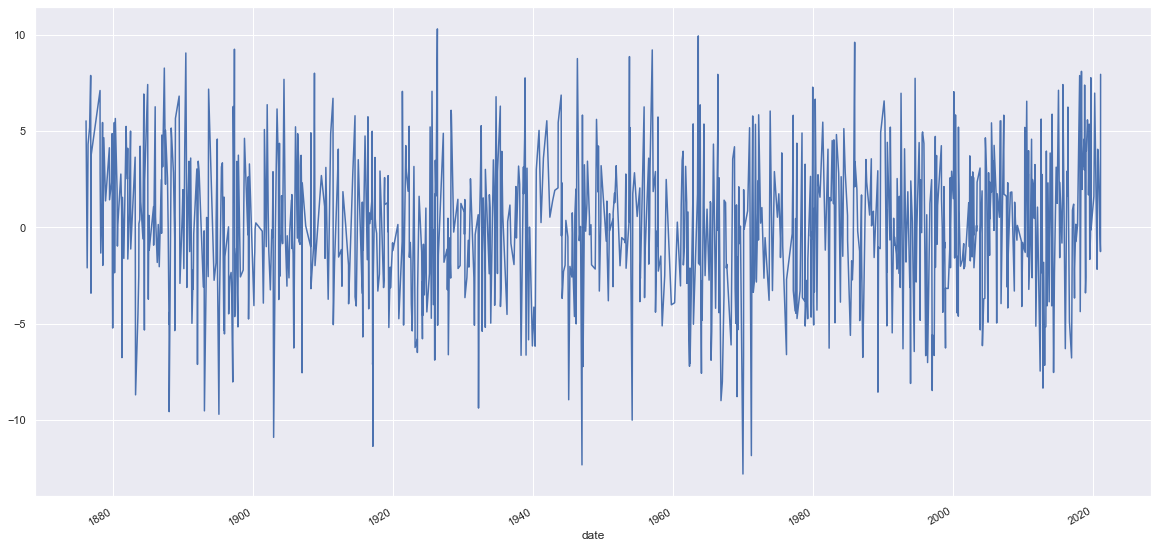

In [48]:
df['remainder'].sample(n =1000).plot(figsize=(20,10)); #I sample to improve the visualisation

In [49]:
df['remainder'].to_csv('temperatures_remainder.csv') #saving the remainders to a csv file

## Remainders analysis

In [50]:
df_r = pd.read_csv('temperatures_remainder.csv', index_col=0, parse_dates=True)
df_r.head()

,remainder
date,
1876-01-01,3.073854
1876-01-02,3.373821
1876-01-03,1.173788
1876-01-04,-4.926245
1876-01-05,-8.926277


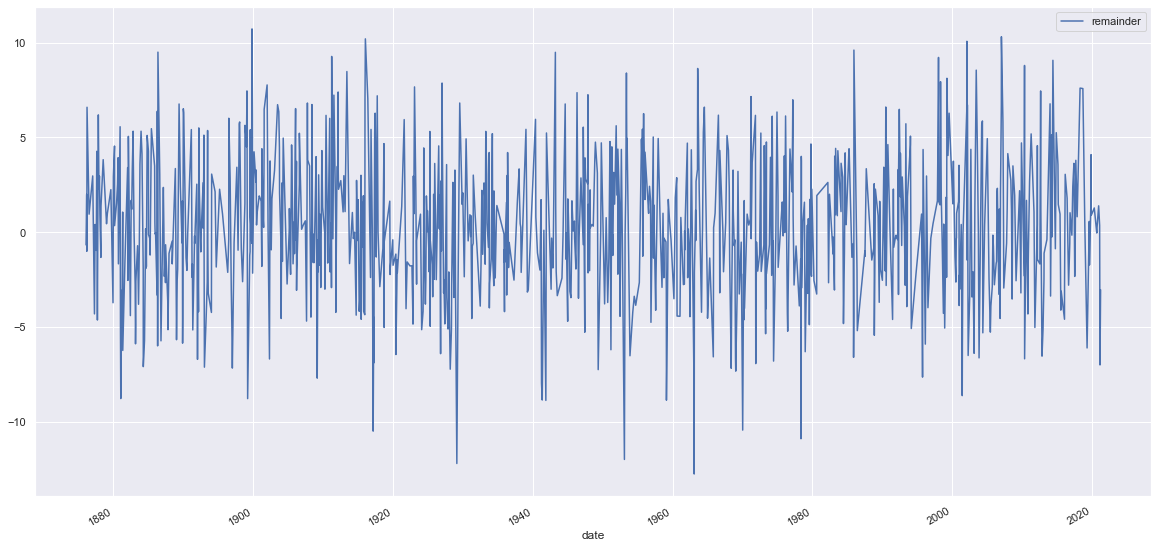

In [51]:
df_r.sample(n=1000).plot();

In [52]:
#Adding a timestep to the rmainder
df_r['timestep'] = range(len(df_r))

In [53]:
df_r['timestep']

date
1876-01-01        0
1876-01-02        1
1876-01-03        2
1876-01-04        3
1876-01-05        4
              ...  
2021-03-27    53046
2021-03-28    53047
2021-03-29    53048
2021-03-30    53049
2021-03-31    53050
Name: timestep, Length: 53051, dtype: int64

### Time lag feature

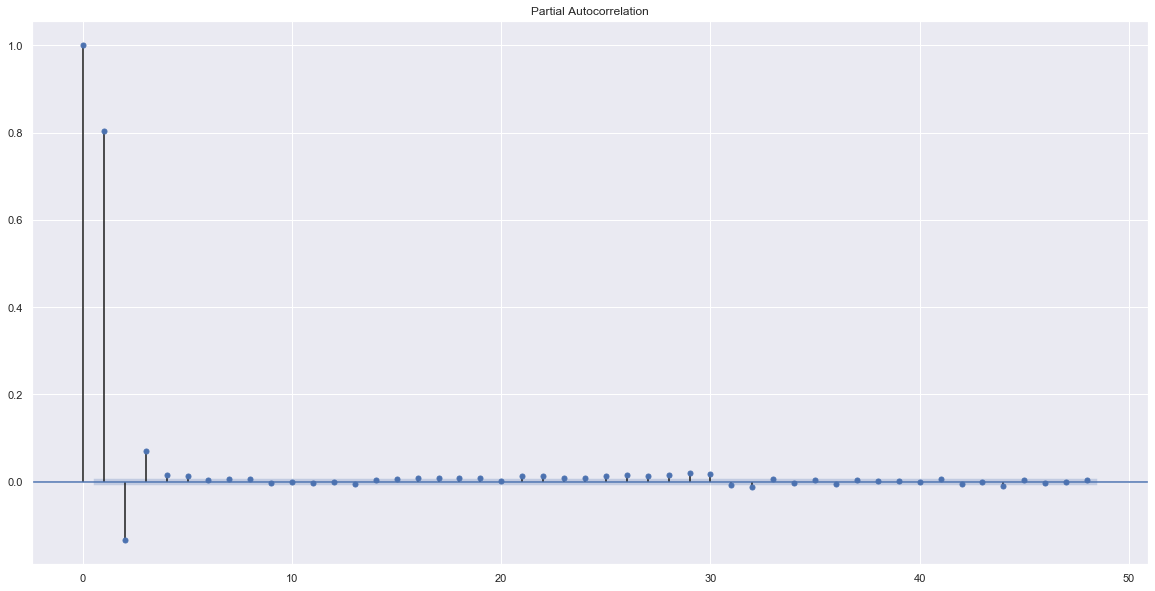

In [54]:
#Plot of the partial autocorrelation function
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_r['remainder']);
#The plot of the autocorrelation function suggests that 4 lags have to be taken into account

In [55]:
df_r['lag1_r'] = df_r['remainder'].shift(1)
df_r.head()

,remainder,timestep,lag1_r
date,,,
1876-01-01,3.073854,0,NaN
1876-01-02,3.373821,1,3.073854
1876-01-03,1.173788,2,3.373821
1876-01-04,-4.926245,3,1.173788
1876-01-05,-8.926277,4,-4.926245


In [56]:
df_r[['remainder']].corrwith(df_r['lag1_r'])

remainder    0.803936
dtype: float64

In [57]:
correlation_r = round(df_r.corr(), 2)

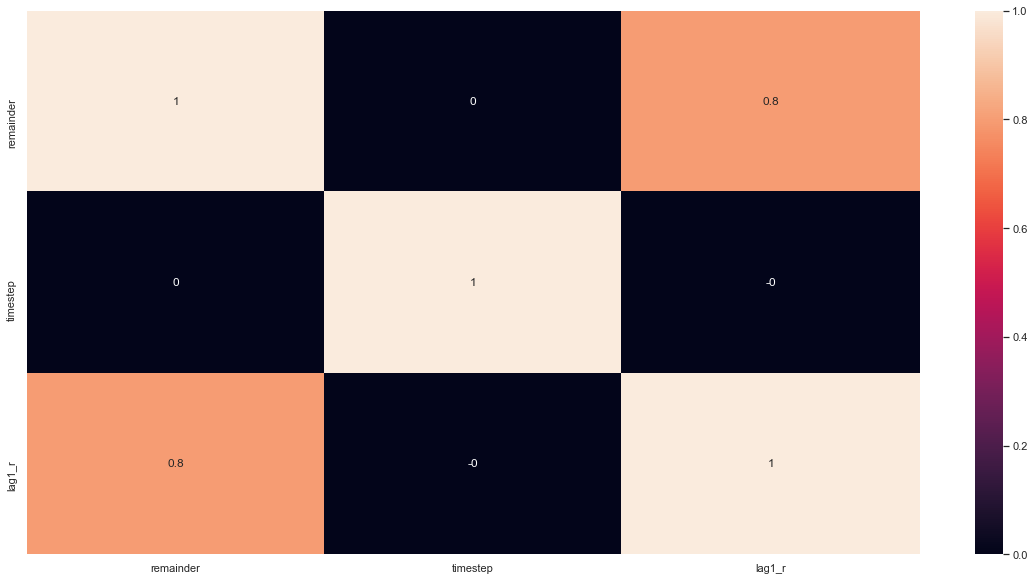

In [58]:
#Heatmap of the correlation between remainder and lag1
sns.heatmap(correlation_r, annot=True);

In [59]:
df_r.dropna(inplace=True) #dropping the NaN value in the lag1 column for the remainders
df_r

,remainder,timestep,lag1_r
date,,,
1876-01-02,3.373821,1,3.073854
1876-01-03,1.173788,2,3.373821
1876-01-04,-4.926245,3,1.173788
1876-01-05,-8.926277,4,-4.926245
1876-01-06,-6.826310,5,-8.926277
...,...,...,...
2021-03-27,1.851076,53046,5.751109
2021-03-28,2.651043,53047,1.851076
2021-03-29,9.351011,53048,2.651043


In [60]:
df_r['lag2_r'] = df_r.remainder.shift(2)
df_r.head()

,remainder,timestep,lag1_r,lag2_r
date,,,,
1876-01-02,3.373821,1,3.073854,NaN
1876-01-03,1.173788,2,3.373821,NaN
1876-01-04,-4.926245,3,1.173788,3.373821
1876-01-05,-8.926277,4,-4.926245,1.173788
1876-01-06,-6.826310,5,-8.926277,-4.926245


In [61]:
df_r['lag3_r'] = df_r.remainder.shift(3)
df_r.head()

,remainder,timestep,lag1_r,lag2_r,lag3_r
date,,,,,
1876-01-02,3.373821,1,3.073854,NaN,NaN
1876-01-03,1.173788,2,3.373821,NaN,NaN
1876-01-04,-4.926245,3,1.173788,3.373821,NaN
1876-01-05,-8.926277,4,-4.926245,1.173788,3.373821
1876-01-06,-6.826310,5,-8.926277,-4.926245,1.173788


In [62]:
df_r['lag4_r'] = df_r.remainder.shift(4)
df_r.head()
df_r.dropna(inplace=True)

### Linear regression model for the remainders

In [63]:
df_r

,remainder,timestep,lag1_r,lag2_r,lag3_r,lag4_r
date,,,,,,
1876-01-06,-6.826310,5,-8.926277,-4.926245,1.173788,3.373821
1876-01-07,-5.726343,6,-6.826310,-8.926277,-4.926245,1.173788
1876-01-08,-8.026376,7,-5.726343,-6.826310,-8.926277,-4.926245
1876-01-09,-11.826408,8,-8.026376,-5.726343,-6.826310,-8.926277
1876-01-10,-8.026441,9,-11.826408,-8.026376,-5.726343,-6.826310
...,...,...,...,...,...,...
2021-03-27,1.851076,53046,5.751109,4.251142,3.151174,0.951207
2021-03-28,2.651043,53047,1.851076,5.751109,4.251142,3.151174
2021-03-29,9.351011,53048,2.651043,1.851076,5.751109,4.251142


In [65]:
X_r = df_r[['timestep','lag1_r','lag2_r','lag3_r','lag4_r']]
y_r = df_r['remainder']

In [66]:
X_r

,timestep,lag1_r,lag2_r,lag3_r,lag4_r
date,,,,,
1876-01-06,5,-8.926277,-4.926245,1.173788,3.373821
1876-01-07,6,-6.826310,-8.926277,-4.926245,1.173788
1876-01-08,7,-5.726343,-6.826310,-8.926277,-4.926245
1876-01-09,8,-8.026376,-5.726343,-6.826310,-8.926277
1876-01-10,9,-11.826408,-8.026376,-5.726343,-6.826310
...,...,...,...,...,...
2021-03-27,53046,5.751109,4.251142,3.151174,0.951207
2021-03-28,53047,1.851076,5.751109,4.251142,3.151174
2021-03-29,53048,2.651043,1.851076,5.751109,4.251142


In [67]:
# Create and fit the model
m_r = LinearRegression()
m_r.fit(X_r, y_r)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
# Create predictions
df_r['predictions_ar_r'] = m_r.predict(X_r)
df_r.head()

,remainder,timestep,lag1_r,lag2_r,lag3_r,lag4_r,predictions_ar_r
date,,,,,,,
1876-01-06,-6.826310,5,-8.926277,-4.926245,1.173788,3.373821,-7.129109
1876-01-07,-5.726343,6,-6.826310,-8.926277,-4.926245,1.173788,-4.799104
1876-01-08,-8.026376,7,-5.726343,-6.826310,-8.926277,-4.926245,-4.513699
1876-01-09,-11.826408,8,-8.026376,-5.726343,-6.826310,-8.926277,-6.788657
1876-01-10,-8.026441,9,-11.826408,-8.026376,-5.726343,-6.826310,-9.740701


In [69]:
df_r.shape

(53046, 7)

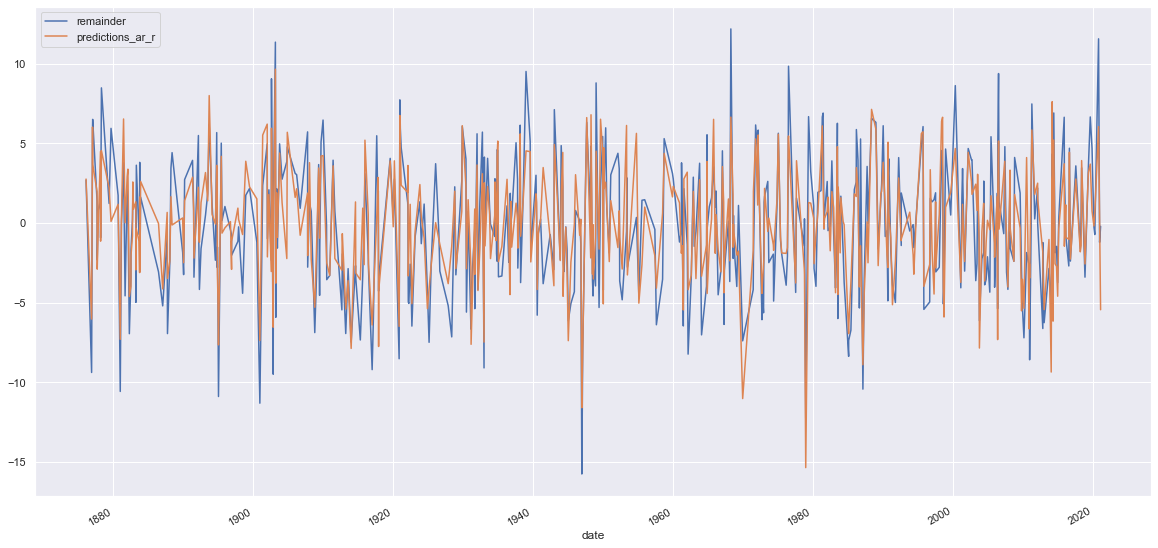

In [70]:
# Plot the original remainder and the predictions
df_r[['remainder', 'predictions_ar_r']].sample(n = 500).plot();

In [71]:
# Adding the residuals column to the dataframe
df_r['residual'] = df_r['remainder'] - df_r['predictions_ar_r']
df_r.head()

,remainder,timestep,lag1_r,lag2_r,lag3_r,lag4_r,predictions_ar_r,residual
date,,,,,,,,
1876-01-06,-6.826310,5,-8.926277,-4.926245,1.173788,3.373821,-7.129109,0.302799
1876-01-07,-5.726343,6,-6.826310,-8.926277,-4.926245,1.173788,-4.799104,-0.927239
1876-01-08,-8.026376,7,-5.726343,-6.826310,-8.926277,-4.926245,-4.513699,-3.512677
1876-01-09,-11.826408,8,-8.026376,-5.726343,-6.826310,-8.926277,-6.788657,-5.037752
1876-01-10,-8.026441,9,-11.826408,-8.026376,-5.726343,-6.826310,-9.740701,1.714259


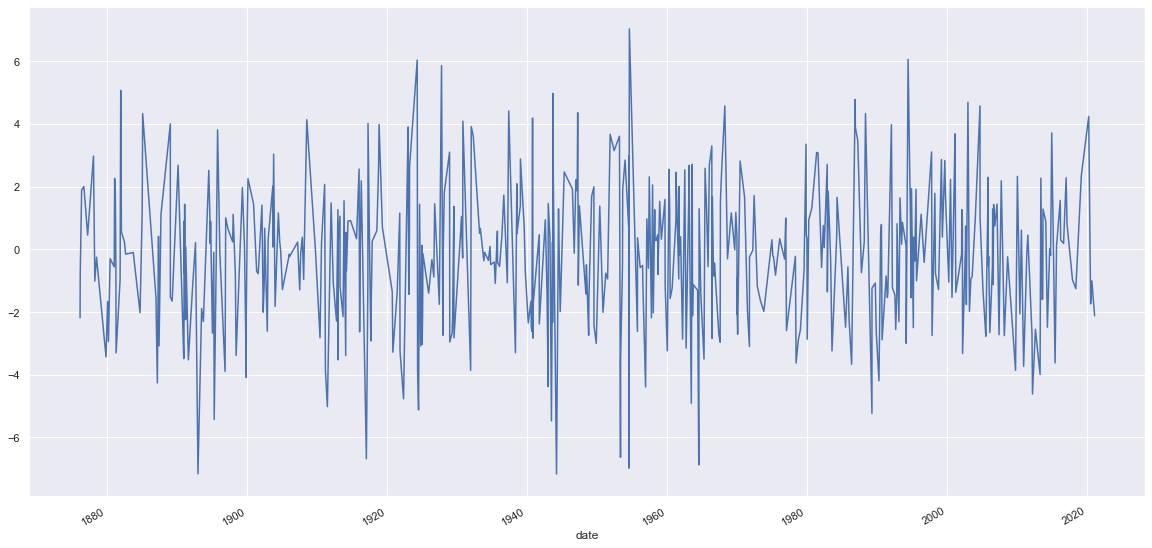

In [72]:
df_r['residual'].sample (n=500).plot();

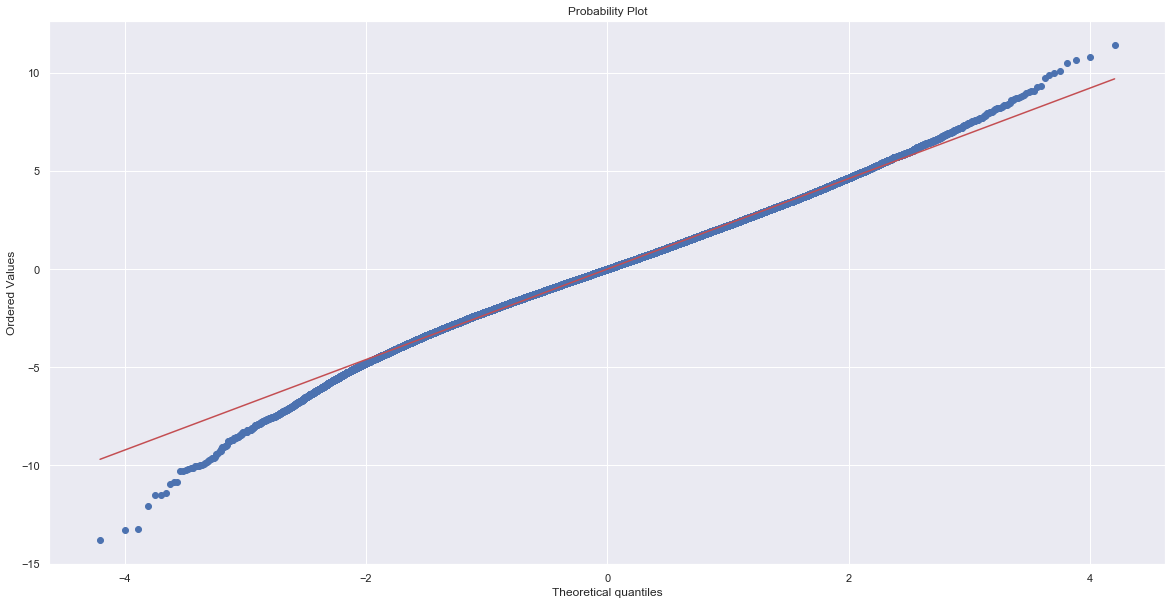

In [73]:
#Q-Q Plot of the residuals (comparison with normal distribution)
stats.probplot(df_r['residual'], dist="norm", plot=py)
py.show()

In [74]:
# The residuals are not normally distributed
test = df_r['residual'].to_numpy()
jarque_bera(test)

(1305.721903006492, 0.0)

In [76]:
#from statsmodels.regression.linear_model import OLS
#from statsmodels.tools import add_constant

#regr = OLS(y_r, add_constant(X_r)).fit()
#print(regr.aic)

239320.32598611095


## Autoregression model for remainders

In [77]:
selected_order_r = ar_select_order(endog=df['remainder'], maxlag=12)

/Users/giudittaparolini/anaconda3/envs/testenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/giudittaparolini/anaconda3/envs/testenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [78]:
selected_order_r.ar_lags #confirms what suggested by the autocorrelation plot

array([1, 2, 3, 4])

In [101]:
ar_model_r = AutoReg(endog=df_r['remainder'], lags=4).fit()

/Users/giudittaparolini/anaconda3/envs/testenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [102]:
ar_model_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                53046
Model:                     AutoReg(4)   Log Likelihood             -119643.512
Method:               Conditional MLE   S.D. of innovations              2.309
Date:                Fri, 30 Apr 2021   AIC                              1.674
Time:                        14:26:31   BIC                              1.675
Sample:                    01-10-1876   HQIC                             1.674
                         - 03-31-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0005      0.010      0.046      0.963      -0.019       0.020
remainder.L1     0.9186      0.004    211.596      0.000       0.910       0.927
remainder.L2    -0.1931      0.006    -32.775      0.000      -0.205      -0.182
remainder.L3     0.0550      0.006      9.332      0.000       0.043       0.067
remainder.L4     0.0163      0.004      3.749      0.000       0.008       0.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2577           -0.0000j            1.2577           -0.0000
AR.2            1.0064           -2.5171j            2.7108           -0.1895
AR.3            1.0064           +2.5171j            2.7108            0.1895
AR.4           -6.6480           -0.0000j            6.6480           -0.5000
-----------------------------------------------------------------------------
"""

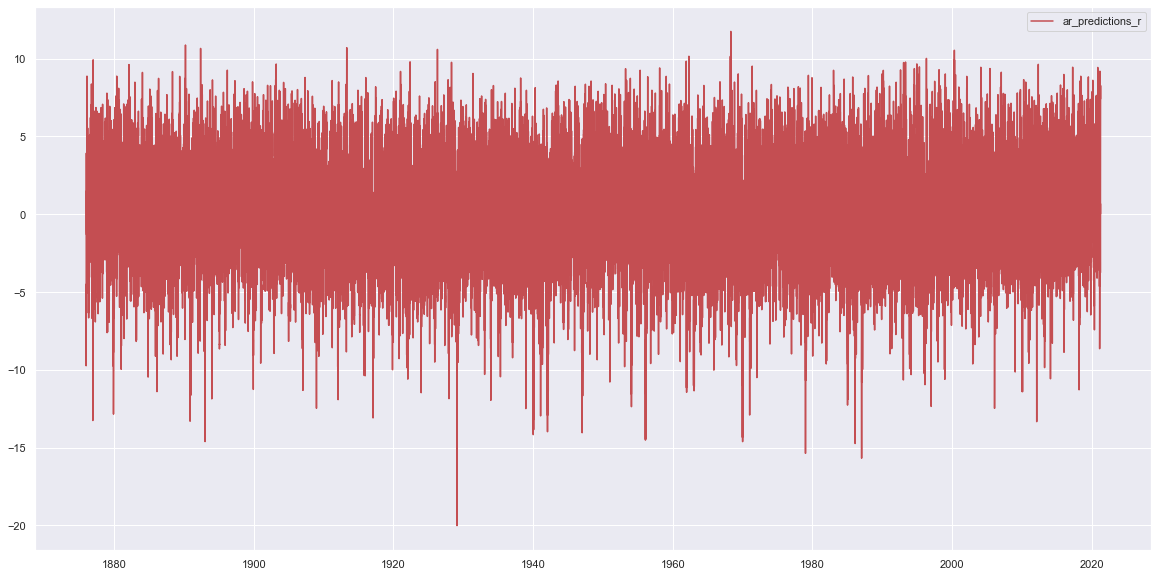

In [81]:
# Plot the prediction
plt.plot(ar_model_r.predict(), label='ar_predictions_r', c='r')
plt.legend()
plt.show()

## Make future predictions with the autoregression model

In [134]:
df_future = pd.DataFrame(index=pd.date_range(start='2021-04-01', end='2021-04-30'))

In [135]:
len(df_future)

30

In [136]:
last_timestep = max(df_r['timestep'])

In [137]:
last_timestep

53050

In [138]:
df_future['timestep']=range(last_timestep +1, last_timestep + 1 + len(df_future))

In [141]:
df_future.head()

,timestep
2021-04-01,53051
2021-04-02,53052
2021-04-03,53053
2021-04-04,53054
2021-04-05,53055


In [148]:
future_seasonal_dummies= pd.get_dummies(df_future.index.month, prefix='month_', sparse=True, drop_first=True).set_index(df_future.index)

In [147]:
future_seasonal_dummies

,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,...,month__21,month__22,month__23,month__24,month__25,month__26,month__27,month__28,month__29,month__30
2021-04-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-02,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-03,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-04,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-05,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-06,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-07,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-08,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-09,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-10,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
df_future = pd.concat([df_future, future_seasonal_dummies], axis=1)

In [128]:
df_future.head()

,timestep
2021-04-01,53051
2021-04-02,53052
2021-04-03,53053
2021-04-04,53054
2021-04-05,53055


In [116]:
ar_model_r.predict(start=53046, end=53047, dynamic=True)

2021-04-01   NaN
2021-04-02   NaN
Freq: D, dtype: float64